### 震動波特徵擷取及模型訓練
#### Writer : 李博業


- 因資料保密之關係, 以下讀檔案的路徑會以文字**filename**表示,而非真實資料路徑

In [ ]:
import os 
import glob 
import numpy as np 
import pandas as pd 
import EntropyHub as EH
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from numpy.fft import fft

In [2]:
#Font字體
from matplotlib.font_manager import FontProperties  
winfont01 = FontProperties(fname=r"C:\Windows\Fonts\heit.ttf", size=12) 

In [ ]:
# filename 為 original data 
filename = filename
data = pd.read_csv(filename, sep = ",", encoding="utf-8")
data.head(4)

,Segment_Head,Segment_Tail,Index,Xaxis,Yaxis,Zaxis
0,1,1903,1,-0.171395,1.940275,-0.015881
1,1,1903,2,-0.239743,1.884467,-0.026090
2,1,1903,3,-0.228417,1.885161,-0.047138
3,1,1903,4,-0.110896,1.932328,-0.037815


#### Data Combination 
- 因資料依四種施壓力及四個感測器位置差異被分成許多檔案, 需要將它們整合
- 整合為一變數data

In [ ]:
path = filename
fnames = glob.glob(path + "\**\*.csv",recursive=True)
data = [[],[],[],[]]

for i in range(0, len(fnames)):
    index = np.int16(np.floor(i/4))
    data_1 = pd.read_csv(fnames[i])
    data_1 = data_1.drop(columns=["FFTx","FFTy","FFTz"],axis=1)
    class_name = [fnames[i].split("\\")[-1].replace("_","-").split("-")[0] for j in range(0,data_1.shape[0])]
    data_1 = pd.concat([data_1,pd.DataFrame(class_name,columns=["class_name"])], axis = 1, verify_integrity=True)
    IIdex = data_1.query("Frequency < 0").index
    data_1 = data_1.drop(IIdex, axis=0)
    data[index].append(data_1)

#移除波數過少的資料(低於500筆)
#i 代表位置(0:Xa, 1:Xb, 2:Ya, 3:Yb)
#j 代表施壓力(0,1,2,3)

for i in range(0, 3+1):
    for j in range(0, 3+1):
        tail = np.unique(data[i][j].Segment_Tail)
        head = np.unique(data[i][j].Segment_Head)
        removed_ht = [[a,b] for a,b in zip(head,tail) if (b-a) < 500]  #要移除的編號
        removed_index = []
        for r in range(0, len(removed_ht)):
            removed_index.extend(data[i][j].query(f" Segment_Head == {removed_ht[r]}").index)
        data[i][j] = data[i][j].drop(removed_index, axis=0)

In [4]:
data[0][0].head() #代表Xa位置 Xa130的資料

,Segment_Head,Segment_Tail,Index,Xaxis,Yaxis,Zaxis,Frequency,FFTx_Amplitude,FFTy_Amplitude,FFTz_Amplitude,class_name
0,1,2078,1,-0.127096,1.907195,-0.031910,0.000000,128.357992,4083.127587,36.099974,Xa130
1,1,2078,2,-0.214250,1.911067,-0.024206,0.000481,2.547345,0.923773,1.065131,Xa130
2,1,2078,3,-0.172775,1.952017,-0.006112,0.000962,2.394951,0.835485,0.280750,Xa130
3,1,2078,4,-0.020248,2.003563,-0.001708,0.001444,3.009108,1.068642,0.523170,Xa130
4,1,2078,5,0.045642,2.017240,-0.016346,0.001925,2.344345,1.719985,0.989907,Xa130


In [18]:
data[0][2]

,Segment_Head,Segment_Tail,Index,Xaxis,Yaxis,Zaxis,Frequency,FFTx_Amplitude,FFTy_Amplitude,FFTz_Amplitude,class_name
0,1,2025,1,-0.135807,1.895158,-0.014897,0.000000,131.316244,3978.967010,37.592627,Xa80
1,1,2025,2,-0.213469,1.914505,-0.014870,0.000494,2.993052,0.546061,0.955492,Xa80
2,1,2025,3,-0.132002,1.936899,-0.013423,0.000988,1.433240,0.384635,1.078344,Xa80
3,1,2025,4,-0.041756,1.982739,-0.033472,0.001481,0.924709,0.976241,0.796267,Xa80
4,1,2025,5,-0.031066,1.995960,-0.029536,0.001975,2.995473,0.822039,0.944419,Xa80
...,...,...,...,...,...,...,...,...,...,...,...
526652,1193643,1195415,1194525,-0.116521,2.019624,-0.041291,0.497462,3.469481,1.266095,0.614727,Xa80
526653,1193643,1195415,1194526,0.115746,1.874884,-0.003664,0.498026,1.455287,0.614447,0.432569,Xa80
526654,1193643,1195415,1194527,0.048477,2.035835,-0.063771,0.498590,3.169273,1.132591,0.729071,Xa80
526655,1193643,1195415,1194528,0.026551,1.891683,0.016887,0.499154,3.378222,1.153644,0.484726,Xa80


#### Labeling  
- 因後續要做分類需要上標籤, 依感測器位置及施壓力分標籤共16個。
- Xa 
    - Xa65
    - Xa80
    - Xa95
    - Xa130
- Xb 
    - Xb65
    - Xb80
    - Xb95
    - Xb130
- Ya 
    - Ya220
    - Ya260
    - Ya300
    - Ya380
- Yb 
    - Yb220
    - Yb260
    - Yb300
    - Yb380


- cal_wave_num : 
    - param : 
        - 輸入感測器位置
        - 0 為 Xa, 1 為Xb, 2 為Ya, 3為Yb 
    - 輸出為該位置各段波的資料數量

In [35]:
def cal_wave_num(pos):

    data_pos = pd.DataFrame()

    for i in range(0, 3+1):
        data_pos = pd.concat([data_pos, data[pos][i]], axis = 0, verify_integrity=True, ignore_index=True)


    data_grouped = list(data_pos.groupby(["Segment_Head","Segment_Tail", "class_name"]))

    all_loc = []
    all_head = []
    all_tail = []
    all_indexnum = []

    for i in range(0, len(data_grouped)):
        count_class_name = np.unique(data_grouped[i][1].loc[:,["class_name"]])[0]
        count_index_number_h = np.unique(data_grouped[i][1].loc[:,["Segment_Head"]])[0]
        count_index_number_t = np.unique(data_grouped[i][1].loc[:,["Segment_Tail"]])[0]
        number = count_index_number_t-count_index_number_h
        all_head.append(count_index_number_h)
        all_tail.append(count_index_number_t)
        all_indexnum.append(number)
        all_loc.append(count_class_name)

    output = pd.DataFrame(zip(all_loc, all_head, all_tail, all_indexnum),\
                        columns= ["class_name", "Segment_Head", "Segment_Tail", "wave_num"])
    return output
    

In [ ]:
# wave_num 為該段波的數量
# class_name 為 label 
cal_wave_num(1)

,class_name,Segment_Head,Segment_Tail,wave_num
0,Xb130,1,967,966
1,Xb65,1,997,996
2,Xb80,1,1307,1306
3,Xb95,1,2204,2203
4,Xb95,4339,6568,2229
...,...,...,...,...
1063,Xb65,1246472,1247344,872
1064,Xb65,1250666,1251675,1009
1065,Xb65,1255176,1255988,812
1066,Xb65,1259377,1260322,945


#### 特徵提取 
- 經過多方嘗試, 本團隊用切塊取極大值的方式效果極佳, 以下為切塊的示例

- random_slice_data_max
    - 取各區段最大值
    - param:
        1. data : 資料
        2. pos : 位置
        3. num : 切片數

In [ ]:
#每一等分取最大振福

def random_slice_data_max(data, pos, num):
    '''  
    data 
    pos : 位置 
        0 -> Xa
        1 -> Xb
        2 -> Ya
        3 -> Yb
    num : 切幾等分 
    '''
    slice_index = np.linspace(0, 0.5, num)[1:num]
    slice_index = np.linspace(0, 0.5, num)[1:num]
    total_data = pd.DataFrame()
    for z in range(0, 4): # z是力
        example_1 = data[pos][z][data[pos][z].Frequency < slice_index[0]].loc[:,["Segment_Head","Segment_Tail","FFTx_Amplitude", "FFTy_Amplitude","FFTz_Amplitude", "class_name"]]\
                .groupby(["Segment_Head","Segment_Tail"]).apply(lambda x:x.max())
        example_1 = pd.DataFrame(example_1)
        new_names = {"FFTx_Amplitude": "FFTx_Amplitude"+str(1),
                     "FFTy_Amplitude": "FFTy_Amplitude"+str(1),
                     "FFTz_Amplitude": "FFTz_Amplitude"+str(1)}
        example_1 = example_1.reset_index(drop=True).rename(columns = new_names)

        for i in range(1, len(slice_index)): #i是切點  
            example_2 = data[pos][z].query(f"Frequency < {slice_index[i]} and Frequency > {slice_index[i-1]}").loc[:,["Segment_Head","Segment_Tail","FFTx_Amplitude", "FFTy_Amplitude","FFTz_Amplitude", "class_name"]]\
            .groupby(["Segment_Head","Segment_Tail"]).apply(lambda x:x.max())
            example_2 = pd.DataFrame(example_2)
            new_names = {"FFTx_Amplitude": "FFTx_Amplitude"+str(i+1),
                         "FFTy_Amplitude": "FFTy_Amplitude"+str(i+1),
                         "FFTz_Amplitude": "FFTz_Amplitude"+str(i+1)}
            example_2 = example_2.reset_index(drop=True).rename(columns = new_names)
            example_1 = pd.merge(left=example_1, right=example_2, how="inner", on =['Segment_Head', 'Segment_Tail','class_name'])
        if z == 0 :
            total_data = example_1
        else:
            total_data = pd.concat([total_data, example_1], axis = 0, verify_integrity=True, ignore_index=True)
    return total_data

In [ ]:
# 以切十塊為例
exp_1 = random_slice_data_max(data, 0, 10)

In [53]:
exp_1.head(5)

,Segment_Head,Segment_Tail,FFTx_Amplitude1,FFTy_Amplitude1,FFTz_Amplitude1,class_name,FFTx_Amplitude2,FFTy_Amplitude2,FFTz_Amplitude2,FFTx_Amplitude3,...,FFTz_Amplitude6,FFTx_Amplitude7,FFTy_Amplitude7,FFTz_Amplitude7,FFTx_Amplitude8,FFTy_Amplitude8,FFTz_Amplitude8,FFTx_Amplitude9,FFTy_Amplitude9,FFTz_Amplitude9
0,1,2078,128.357992,4083.127587,36.099974,Xa130,19.045750,14.166618,24.695610,29.293866,...,2.626262,4.569690,2.585464,2.276482,6.541043,4.089064,1.928640,5.552386,3.614318,2.201766
1,4544,6481,121.941518,3808.073081,33.078000,Xa130,22.251669,14.890844,11.624025,28.918423,...,2.159985,3.679214,2.256582,2.044124,4.350336,2.907558,1.879337,5.399984,2.286200,1.655007
2,8804,10760,124.393957,3846.764284,34.911610,Xa130,21.301692,15.989202,14.895162,28.040685,...,2.373301,4.212958,1.945391,2.036227,5.331618,3.091522,2.107222,5.276813,3.399689,1.956968
3,13094,15170,128.994947,4082.883088,37.294364,Xa130,15.290998,14.416036,17.967302,35.133458,...,2.343268,3.607413,2.282151,1.994728,4.559290,2.539331,1.571029,5.844351,2.654912,1.457851
4,17359,19418,128.390287,4051.190050,36.668222,Xa130,26.851615,12.316387,25.209910,32.410869,...,2.838323,3.770598,3.518398,2.070583,4.481467,2.291585,2.510453,5.588660,2.445783,2.222841


#### 切塊示意圖

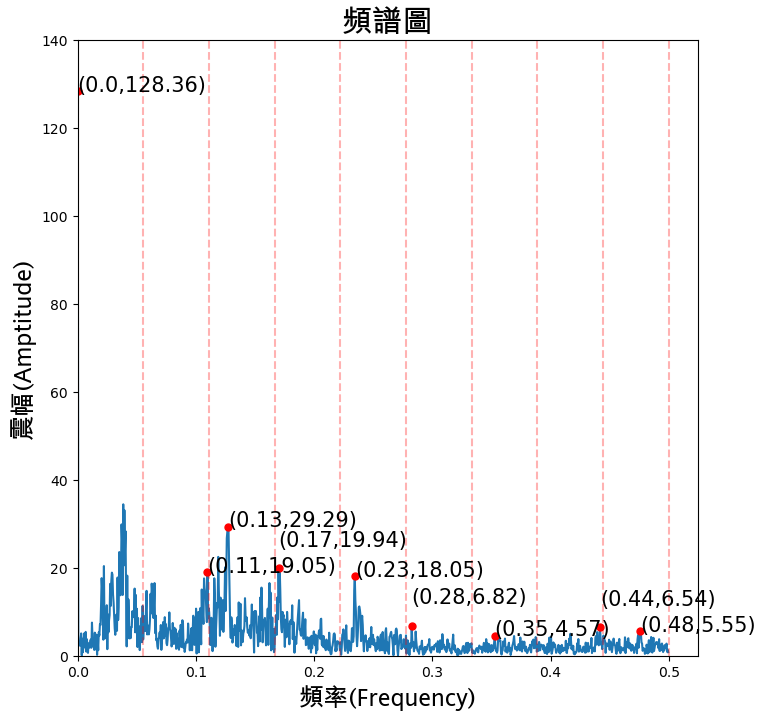

In [ ]:
#畫示意圖

example = pd.DataFrame(list(data[0][0].groupby(['Segment_Head', 'Segment_Tail']))[0][1])
exp_1 = random_slice_data_max(data, 0, 10)

amp = []
freq = []

for i in range(1, 9+1):
    name = "FFTx_Amplitude" + str(i)
    freq.append(list(example.query(f"FFTx_Amplitude == {exp_1[name]}").Frequency))
    amp.append(list(example.query(f"FFTx_Amplitude == {exp_1[name]}").FFTx_Amplitude))


# 命名
name = {}

name["Segment_Head"] = "此波頭Index"
name["Segment_Tail"] = "此波尾Index"
name["FFTx_Amplitude1"] = "X軸-區段一"
name["FFTy_Amplitude1"] = "Y軸-區段一"
name["FFTz_Amplitude1"] = "Z軸-區段一"

name["FFTx_Amplitude2"] = "X軸-區段二"
name["FFTy_Amplitude2"] = "Y軸-區段二"
name["FFTz_Amplitude2"] = "Z軸-區段二"
name["class_name"] = "施壓力種類"

name["FFTx_Amplitude3"] = "X軸-區段三"
name["FFTy_Amplitude3"] = "Y軸-區段三"
name["FFTz_Amplitude3"] = "Z軸-區段三"


name["FFTx_Amplitude6"] = "X軸-區段六"
name["FFTy_Amplitude6"] = "Y軸-區段六"
name["FFTz_Amplitude6"] = "Z軸-區段六"

name["FFTx_Amplitude7"] = "X軸-區段七"
name["FFTy_Amplitude7"] = "Y軸-區段七"
name["FFTz_Amplitude7"] = "Z軸-區段七"

name["FFTx_Amplitude8"] = "X軸-區段八"
name["FFTy_Amplitude8"] = "Y軸-區段八"
name["FFTz_Amplitude8"] = "Z軸-區段八"

name["FFTx_Amplitude9"] = "X軸-區段九"
name["FFTy_Amplitude9"] = "Y軸-區段九"
name["FFTz_Amplitude9"] = "Z軸-區段九"


exp_1.rename(columns=name)


# 製圖

plt.figure(figsize=[8,8])
plt.plot(example["Frequency"], example["FFTx_Amplitude"])
plt.xlim(0)
plt.ylim(0, 140)
plt.xlabel("頻率(Frequency)", fontproperties = winfont01, size = 18)
plt.ylabel("震幅(Amptitude)", fontproperties = winfont01, size = 18)
plt.title("特徵擷取示意圖", fontproperties = winfont01, size = 22)
plt.vlines(x = np.linspace(0, 0.5, 10), ymin = 0, ymax = 140,colors = "red", alpha = 0.3, linestyle = "--")

z = 0 
for x,y in zip(freq,amp):

    plt.text(x[0],y[0]+5*(z==3 or z == 7 or z == 5), f"({np.round(x[0],2)},{np.round(y[0],2)})", fontsize = 15)
    plt.plot(x[0], y[0], "ro", markersize = 5)
    z += 1


plt.show()

#### 尋找最佳切片數 
- 以在Yb處,並切割25片示例
- 先以隨機森林為主要模型
    - 因為容易解釋且運作模式似線性的交互作用，方便我們考慮三軸交互結果

In [ ]:
#切割訓練集及測試集

example_3 = random_slice_data_max(data,3,25) # 3 代表 Yb, 切割25片

train_index = np.random.randint(low = 0, high = (example_3.shape[0])-1, size = np.int16(np.round(example_3.shape[0]*0.7)))
test_index = [i for i in range(0, example_3.shape[0]) if i not in train_index]



train_accuracy = [] # 訓練集準確率
test_accuracy = []  # 測試集準確率
sliced_number = []  # 存切片數

pos = 3 #位置

for i in range(2, 25+1):     # 嘗試從2到25片數
    result = random_slice_data_max(data, pos, i)
    train_data = result.drop(columns=["class_name"]).iloc[train_index,:]
    train_class = result.loc[train_index,"class_name"]
    test_data = result.drop(columns=["class_name"]).iloc[test_index,:]
    test_class = result.loc[test_index,"class_name"]
    clf = RandomForestClassifier()
    clf.fit(train_data, train_class)
    pred_y = clf.predict(test_data)
    pred_train = clf.predict(train_data)
    sliced_number.append(i)
    test_accuracy.append(sum(test_class == pred_y)/len(pred_y))
    train_accuracy.append(sum(train_class == pred_train)/len(pred_train))

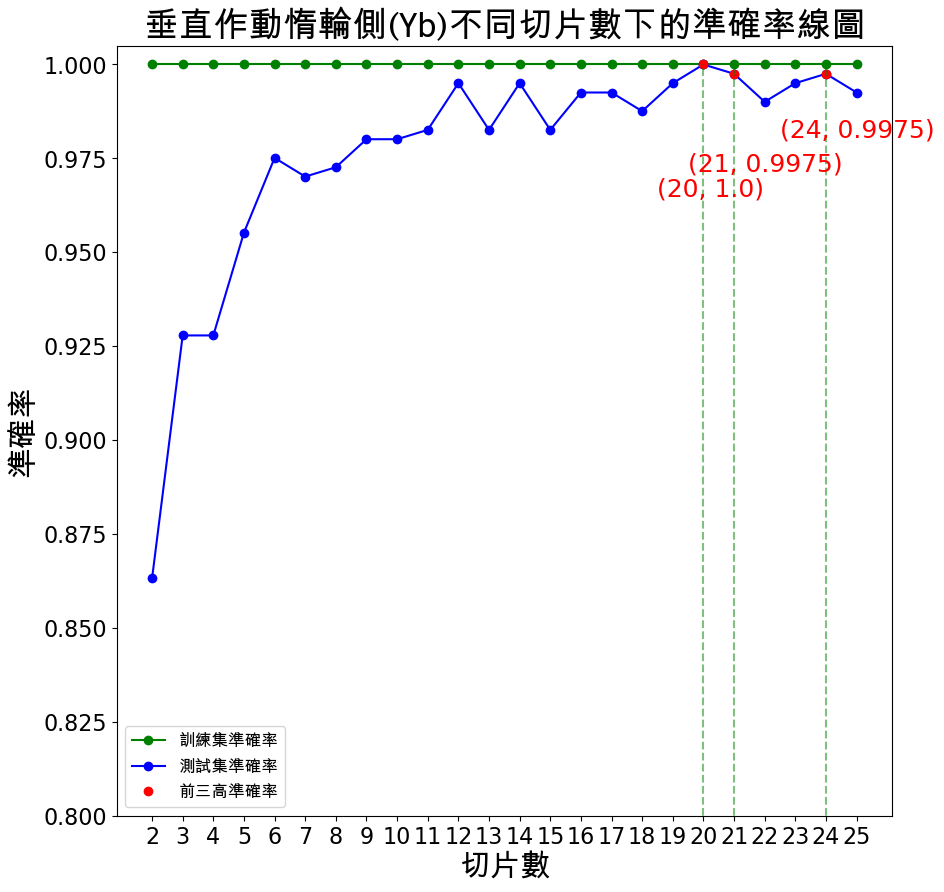

In [21]:
plt.figure(figsize=[10,10])
result = pd.DataFrame(zip(sliced_number, train_accuracy, test_accuracy), columns = ["sliced_number", "train_accuracy", "test_accuracy"])

plt.plot(result.sliced_number, result.train_accuracy, "go-")
plt.plot(result.sliced_number, result.test_accuracy, "bo-")
plt.plot(top3_sliced, top3_test_acc, "ro")

#範圍設定
plt.ylim(0.8,1.005)

#名稱
plt.xlabel("切片數", fontproperties = winfont01, size = 22)
plt.ylabel("準確率", fontproperties= winfont01, size = 22)
plt.title("垂直作動惰輪側(Yb)不同切片數下的準確率線圖", fontproperties= winfont01, size = 25)



#ticks
plt.xticks(range(2, 25+1), [ str(i )for i in range(2, 25+1)], size = 16)
plt.yticks(size = 16)

#vlines
plt.vlines(x = top3_sliced, ymin = 0 , ymax = 1 , linestyle = "--", color = "green", alpha = 0.5)

z = 0 
for i,j in zip(top3_sliced, top3_test_acc):
    plt.text(i-1.5, j-0.035+z*0.009, f"({i}, {np.round(j,4)})", size = 18, color = "red")
    z += 1


#legend
plt.legend(["訓練集準確率", "測試集準確率", "前三高準確率"], prop = winfont01, fontsize = "large", loc = "best")

plt.savefig("Yb_sliced.jpg")

plt.show()

#### 交叉驗證

In [22]:
#cross validation 
best_accuracy = [[],[],[],[],[],[],[],[],[],[]]
#best_imp = [[],[],[],[],[],[],[],[],[],[]]
alpha_number = [24]
pos = 0

result = random_slice_data_max(data, pos, 2)
wave_num = result.shape[0] 
folds = 10

sequ = [ i for i in range(0, 9+1)]
index_cross = []

for i in range(1, int(np.ceil(wave_num/folds)) + 1):
    index_cross += sequ
    
index_cross = np.random.permutation(index_cross[:wave_num])


for i in range(0, folds):
    test_index = np.array([q for q in range(0, wave_num)])[index_cross == i ]
    train_index = np.array([q for q in range(0, wave_num)])[index_cross != i ]
    for z in alpha_number:
        result = random_slice_data_max(data, pos, z)
        crotrain_data = result.drop(columns=["class_name"]).iloc[train_index,:]
        crotrain_class = result.loc[train_index,"class_name"]
        crotest_data = result.drop(columns=["class_name"]).iloc[test_index,:]
        crotest_class = result.loc[test_index,"class_name"]
        clf = RandomForestClassifier()
        clf.fit(crotrain_data, crotrain_class)
        pred_y = clf.predict(crotest_data)
        best_accuracy[i].append(sum(crotest_class == pred_y)/len(pred_y))

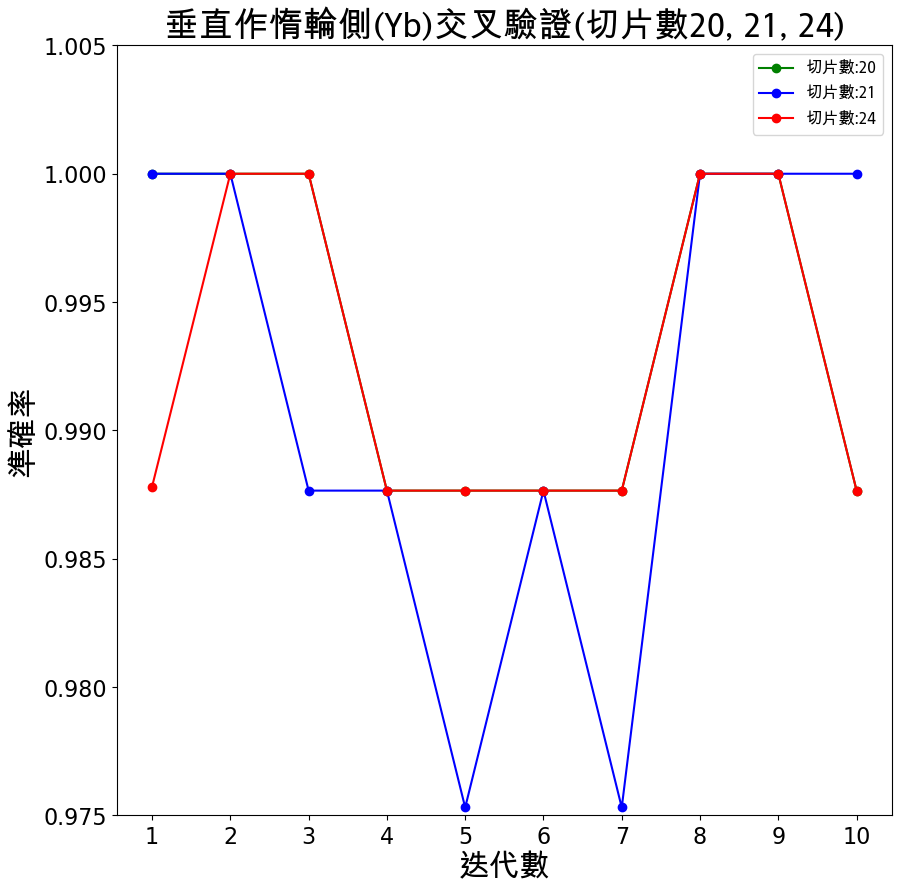

In [27]:
plt.figure(figsize=[10,10])
#result = pd.DataFrame(zip(alpha_number, train_accuracy, test_accuracy), columns = ["sliced_number", "train_accuracy", "test_accuracy"])

best_accuracy = np.array(best_accuracy)

    
plt.plot([a for a in range(0, 9+1)], best_accuracy[:,0], "go-")
plt.plot([a for a in range(0, 9+1)], best_accuracy[:,1], "bo-")
plt.plot([a for a in range(0, 9+1)], best_accuracy[:,2], "ro-")

#範圍設定
plt.ylim(0.975,1.005)

#名稱
plt.xlabel("迭代數", fontproperties = winfont01, size = 22)
plt.ylabel("準確率", fontproperties= winfont01, size = 22)
plt.title("垂直作惰輪側(Yb)交叉驗證(切片數20, 21, 24)", fontproperties= winfont01, size = 25)


#ticks
plt.xticks(range(0, 9+1), [ str(i )for i in range(1, 10+1)], size = 16)
plt.yticks(size = 16)

#vlines
#plt.vlines(x = top3_sliced, ymin = 0 , ymax = 1 , linestyle = "--", color = "green", alpha = 0.5)

# for i,j in zip(top3_sliced, top3_test_acc):
#     plt.text(i-3.5, j-0.035, f"({i}, {np.round(j,2)})", size = 18, color = "red")


#legend
plt.legend(["切片數:20", "切片數:21", "切片數:24"], prop = winfont01, fontsize = "large", loc = "best")

plt.savefig("Yb_cross_validation_20.jpg")
plt.show()

#### 各位置模型訓練
- 以上述的例子對各位置尋找後結論為,
    - Xa 
        - 切片數選擇24, 準確率穩定高於0.95
    - Xb 
        - 切片數選擇20, 準確率穩定高於0.95
    - Ya 
        - 切片數選擇4, 準確率穩定於1左右
    - Yb 
        - 切片數選擇20

In [ ]:
#Xa 

result = random_slice_data_max(data, pos, 24)

train_index = np.random.randint(low = 0, high = (result.shape[0])-1, size = np.int16(np.round(result.shape[0]*0.7)))
test_index = [i for i in range(0, result.shape[0]) if i not in train_index]

train_data = result.drop(columns=["class_name"]).iloc[train_index,:]
train_class = result.loc[train_index,"class_name"]
clf = RandomForestClassifier()
clf.fit(train_data, train_class)

RandomForestClassifier()

In [ ]:
#Xb 
result = random_slice_data_max(data, pos, 20)

train_index = np.random.randint(low = 0, high = (result.shape[0])-1, size = np.int16(np.round(result.shape[0]*0.7)))
test_index = [i for i in range(0, result.shape[0]) if i not in train_index]

train_data = result.drop(columns=["class_name"]).iloc[train_index,:]
train_class = result.loc[train_index,"class_name"]
clf = RandomForestClassifier()
clf.fit(train_data, train_class)

RandomForestClassifier()

In [ ]:
#Ya 
result = random_slice_data_max(data, pos, 4)

train_index = np.random.randint(low = 0, high = (result.shape[0])-1, size = np.int16(np.round(result.shape[0]*0.7)))
test_index = [i for i in range(0, result.shape[0]) if i not in train_index]

train_data = result.drop(columns=["class_name"]).iloc[train_index,:]
train_class = result.loc[train_index,"class_name"]
clf = RandomForestClassifier()
clf.fit(train_data, train_class)

RandomForestClassifier()

In [ ]:
#Yb 

result = random_slice_data_max(data, pos, 20)

train_index = np.random.randint(low = 0, high = (result.shape[0])-1, size = np.int16(np.round(result.shape[0]*0.7)))
test_index = [i for i in range(0, result.shape[0]) if i not in train_index]

train_data = result.drop(columns=["class_name"]).iloc[train_index,:]
train_class = result.loc[train_index,"class_name"]
clf = RandomForestClassifier()
clf.fit(train_data, train_class)

RandomForestClassifier()

In [ ]:
import joblib
joblib.dump(clf, "Yb_model_20.joblib", compress=0)

#### 變數重要性討論
- 各位置選出最佳切片數並訓練完模型後會討論其重要變數
- 目前只是演示程式碼, 各位置結果紀錄於 github report 中

<Figure size 1000x1000 with 0 Axes>

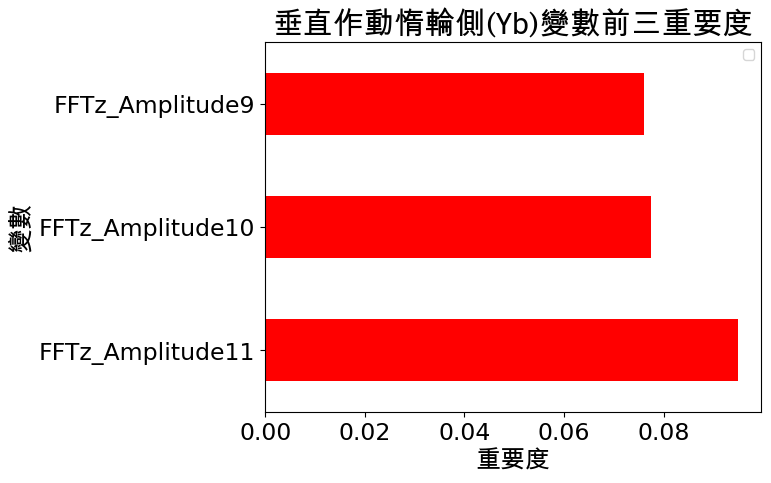

In [ ]:
Y_impo = clf.feature_importances_[clf.feature_importances_.argsort()[::-1][:3]]
X_name = clf.feature_names_in_[clf.feature_importances_.argsort()[::-1][:3]]

plt.figure(figsize=[10,10])
pd.DataFrame(zip(X_name, Y_impo), columns=["X", "Amp"]).plot.barh(x = "X",  y= "Amp", color = "red", fontsize = 13)
plt.legend("")
plt.title("垂直作動惰輪側(Yb)變數前三重要度", fontproperties = winfont01, size =22)
plt.xlabel("重要度", fontproperties = winfont01, size = 18)
plt.ylabel("變數", fontproperties = winfont01, size = 18)
plt.yticks(size = 17)
plt.xticks(size = 17)

#plt.savefig("Xa_importance_barplot.jpg",)
plt.show( )